In [3]:
import sys
import os
import string
from itertools import islice, combinations_with_replacement

import altair
from altair import Chart, Color, X, Y, Row
import pandas as pd
import numpy as np
from IPython.display import Audio, display
from scipy import fft, ifft
from scipy.signal import resample, sawtooth, square, fftconvolve
from scipy.linalg import toeplitz
from scipy.io import wavfile
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../io")
import shift_wavs
sys.path.append("../utils")
from plot_stuff import plot_signals
from compare_signals import compare_signals

## Experiment using superposition of simple signals

### Observations

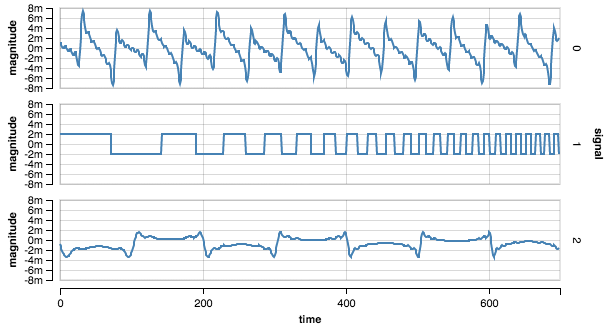

In [74]:
ts = np.linspace(0.0,3.0,num=8000*3)
hz1 = 170
sig1 = np.sum([np.sin(ts*harm*hz1*2.0*np.pi+np.sin(ts*500)/4.0, dtype=np.float32) * 0.005/(harm+1) for harm in range(7)],axis=0)
hz2 = 430
sig2 = square(np.sin((ts*4))**4*hz2*2.0*np.pi).astype(np.float32) * 0.002
sig3 = np.sum([np.sin(50+(np.sin(ts*250)*0.01)*ts*harm*hz2*2.0*np.pi).astype(np.float32) * 0.002/(harm+1) for harm in range(10)],axis=0)
sigs = np.vstack((sig1,sig2,sig3))
plot_signals(sigs[:,300:1000]).configure_cell(height=80).display()

In [75]:
display(Audio(sig1,rate=8000))
display(Audio(sig2,rate=8000))
display(Audio(sig3,rate=8000))
wavfile.write("space_sound.wav",8000,sig3)

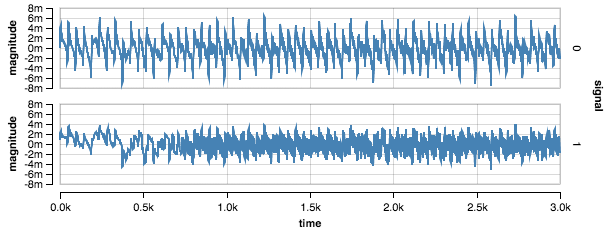

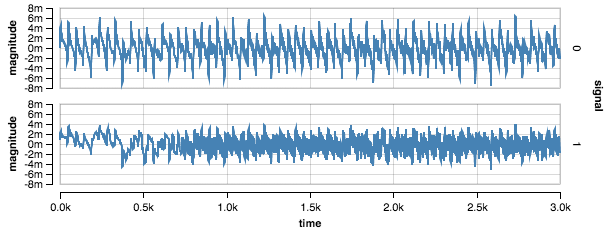

In [77]:
# mixing_system = np.array([[0.9, 0.7, 0.9]])
mixing_system = np.array([[0.77, 0.34, 0.43],
                           [0.3, 0.75, 0.49]])

mic_obs = mixing_system @ sigs + np.random.randn(1, sigs.shape[1]) * 0.0001

plot_signals(mic_obs[:,:3000]).configure_cell(height=80).display()
display(Audio(mic_obs[0,:],rate=8000,autoplay=False))
display(Audio(mic_obs[1,:],rate=8000,autoplay=False))


### Construct Delayed Observation Matrix

In [78]:
#num_samples = mic_obs.shape[1]
clip_start = 8000
clip_end = 16000
num_delays = 5
num_signals = mic_obs.shape[0]

In [79]:
shifted_obs = np.zeros((num_signals*num_delays, clip_end-clip_start), dtype=mic_obs.dtype)
num_samples = shifted_obs.shape[1]

In [80]:
for sig_idx in range(num_signals):
    first_col = mic_obs[sig_idx,clip_start:(clip_start - num_delays):-1]
    first_row = mic_obs[sig_idx, clip_start:clip_end]
    shifted_obs[(num_delays*sig_idx):(num_delays + num_delays*sig_idx)] = toeplitz(first_col, first_row)

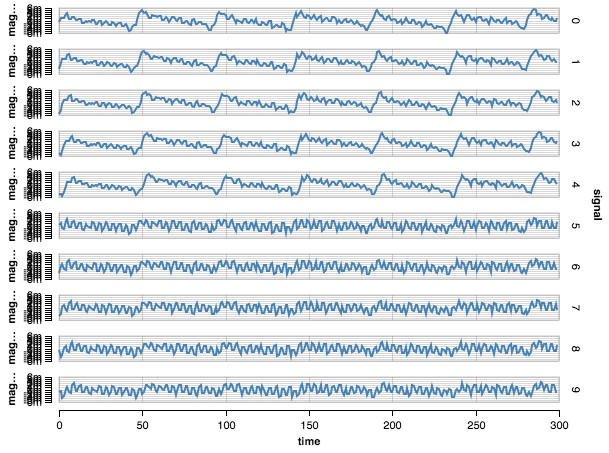

In [81]:
plot_signals(shifted_obs[:,:300]).configure_cell(height=25)

### Use FastICA on signals

In [82]:
from sklearn.decomposition import FastICA

fastica = FastICA(n_components=num_signals*num_delays, max_iter=1000, tol=0.0001, whiten=True)
components = fastica.fit_transform(shifted_obs.T).T

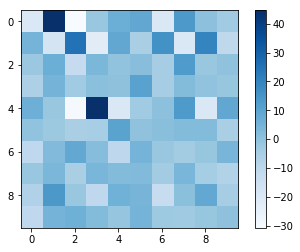

In [83]:
plt.imshow(fastica.components_, cmap='Blues', interpolation='nearest')
plt.colorbar()

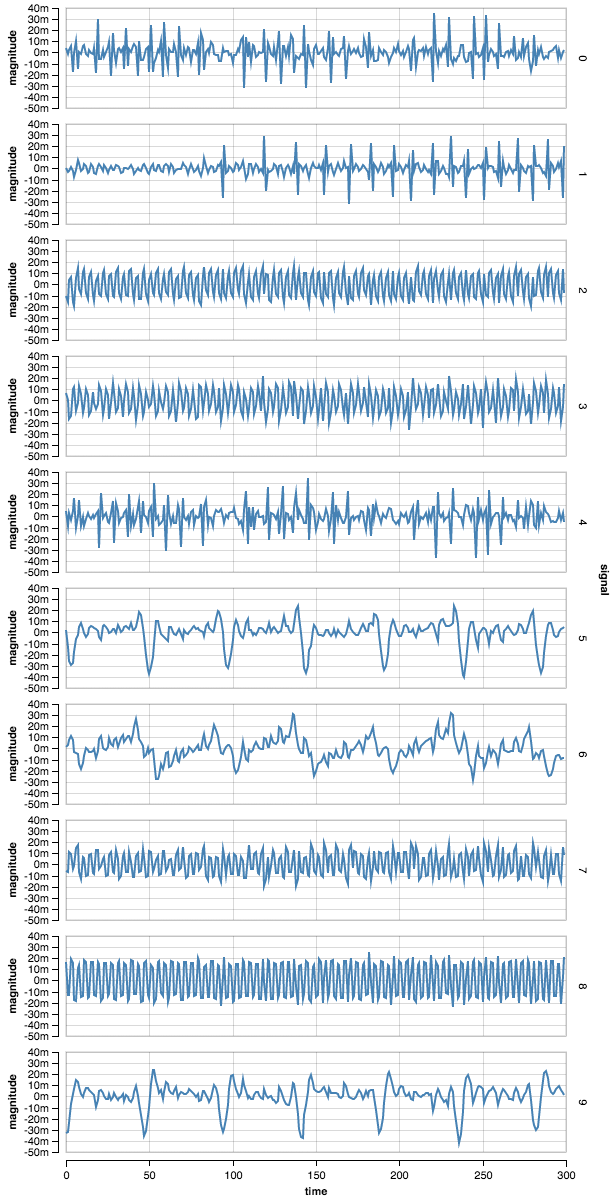

In [84]:
plot_signals(components[:,:300]).configure_cell(height=100)

In [85]:
for i, component in enumerate(components):
    print(i,end=': ')
    display(Audio(component, rate=8000))

0: 

1: 

2: 

3: 

4: 

5: 

6: 

7: 

8: 

9: 

## Similarity Metric

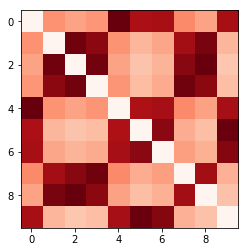

In [86]:
# Search problem: over pairs of signals find a filter that minimizes the mean square difference
# between one signal and a filtered version of another
com_sims = compare_signals(components)

plt.imshow(com_sims, cmap='Reds', interpolation='nearest')

## Agglomerative Clustering

In [87]:
agg = AgglomerativeClustering(n_clusters=sigs.shape[0])
agg.fit(com_sims)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=3,
            pooling_func=<function mean at 0x10ab34840>)

[0 1 2 1 0 0 0 1 1 0]


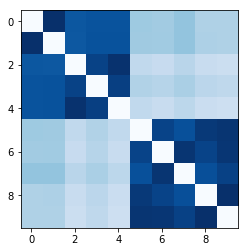

In [88]:
sim_idxs = np.argsort(agg.labels_)
print(agg.labels_)
plt.imshow(com_sims[sim_idxs][:,sim_idxs], cmap='Blues', interpolation='nearest')

## Reconstruction

In [89]:
# Get back into space of the augmented input
num_srcs = sigs.shape[0]
reconstructed = np.zeros((num_srcs,*shifted_obs.shape), dtype=shifted_obs.dtype)

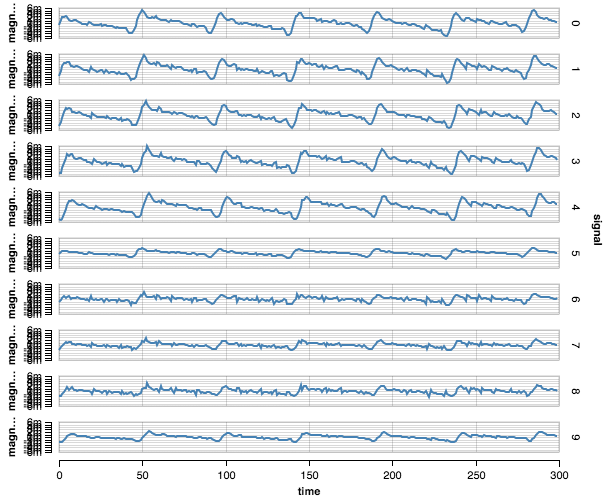

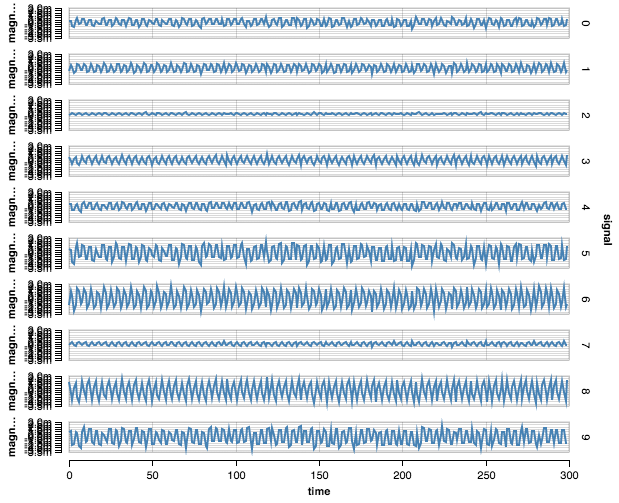

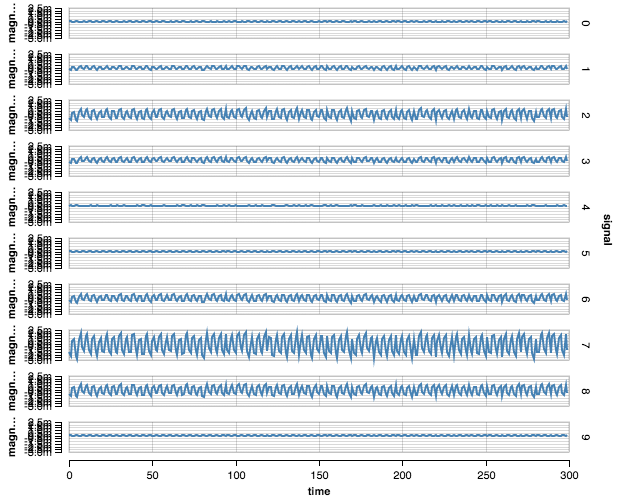

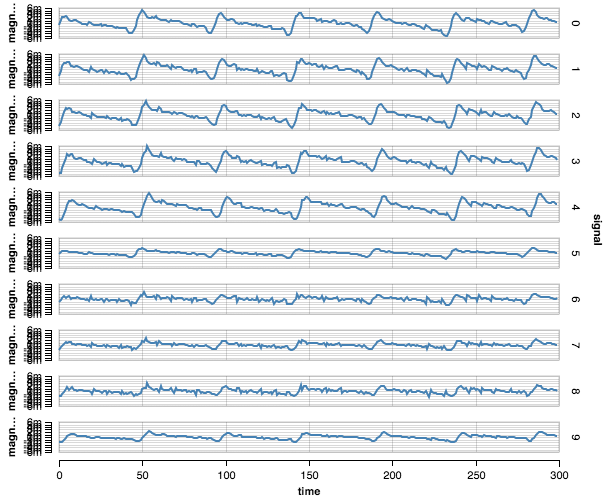

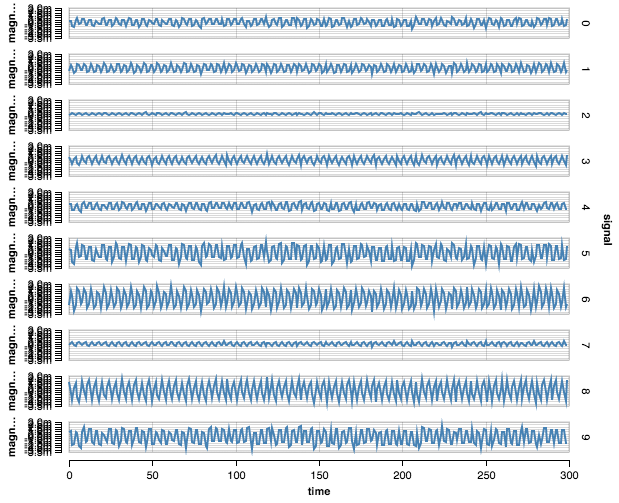

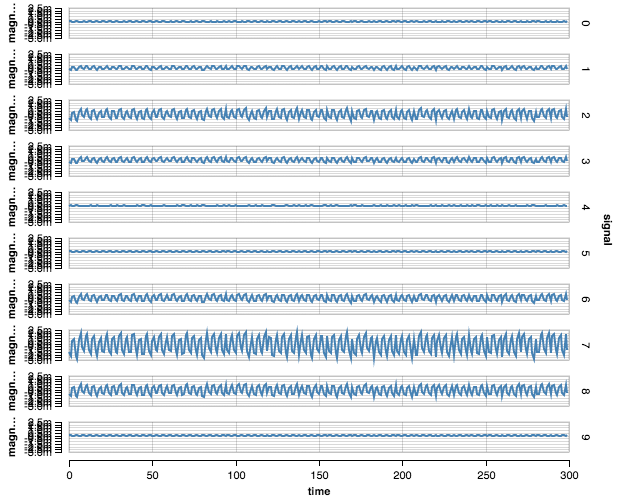

In [90]:
for i in range(3):
    reconstructed[i] = (np.linalg.pinv(fastica.components_) @ np.diag(agg.labels_ == i) @ fastica.components_) @ shifted_obs
    plot_signals(reconstructed[i,:,:300]).configure_cell(height=30).display()

In [91]:
# Reconstruct sources, accounting for original artificial lags
src_imgs_est = np.zeros((num_srcs, num_signals, num_samples), dtype=shifted_obs.dtype)
for clus in range(num_srcs):
    for lag in range(num_delays):
        for sig in range(num_signals):
            for n in range(num_samples - num_delays):
                src_imgs_est[clus, sig, n] = reconstructed[clus, (sig)*num_delays + lag, n + lag]

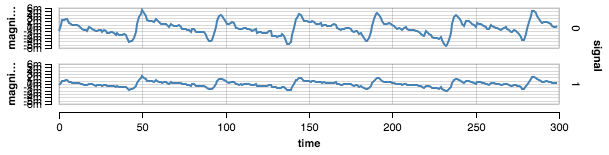

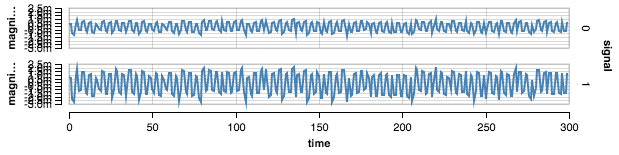

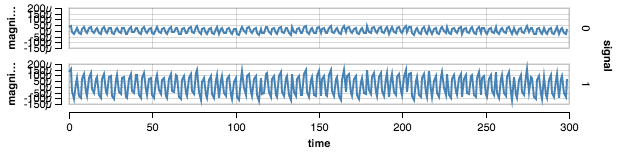

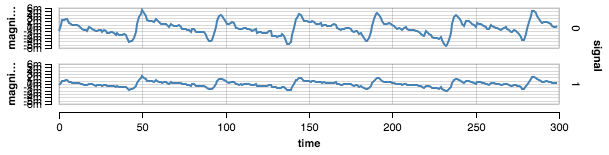

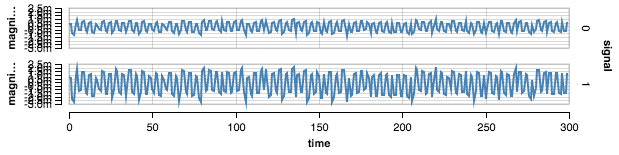

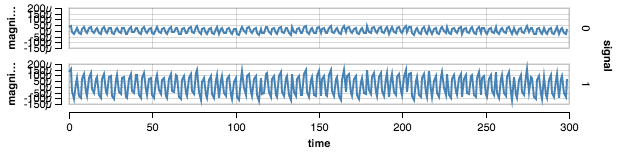

In [92]:
plot_signals(src_imgs_est[0,:,:300]).configure_cell(height=40).display()
plot_signals(src_imgs_est[1,:,:300]).configure_cell(height=40).display()
plot_signals(src_imgs_est[2,:,:300]).configure_cell(height=40).display()

In [93]:
display(Audio(src_imgs_est[0,:,:], rate=8000))
display(Audio(src_imgs_est[1,:,:], rate=8000))
display(Audio(src_imgs_est[2,:,:], rate=8000))

## Use real audio data

### Prepare the data

In [21]:
audio_path = "../audio/xp1/"
wav_paths = os.listdir(audio_path)
wav_paths = [os.path.join(audio_path,wp) for wp in wav_paths if ".wav" in wp]
shifted_sigs = list(shift_wavs.shift_wavs(*wav_paths))
shifted_sigs = np.concatenate(shifted_sigs).reshape(len(wav_paths),-1)
shifted_sigs.shape

(5, 4849765)

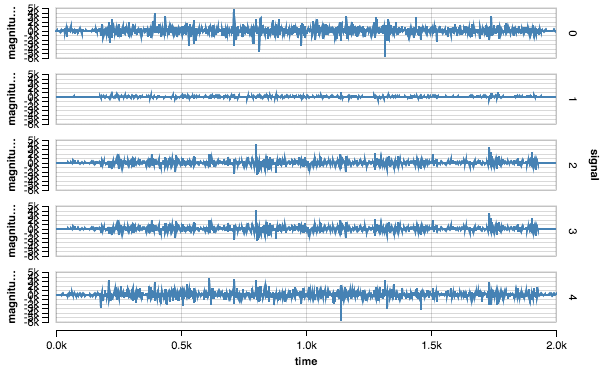

In [22]:
resampled_sigs = resample(shifted_sigs[:, ::200], 2000, axis=1)
plot_signals(resampled_sigs).configure_cell(height=50)
# sigs_df = pd.DataFrame(data=resampled_sigs.T, index=range(resampled_sigs.shape[1]), 
#              columns=[a for a in islice(string.ascii_lowercase, resampled_sigs.shape[0])]).reset_index()
# sigs_df = pd.melt(sigs_df, id_vars=('index',))
# (Chart(sigs_df)
#     .encode(X('index'), Y('value'), Row('variable'))
#     .mark_line())

In [23]:
sigs_clip = shifted_sigs[:3, 10*44100:20*44100]
sigs_clip_8k = resample(sigs_clip, 80000, axis=1)

Example audio clip

In [24]:
display(Audio(sigs_clip[[2,0]], rate=44100))
display(Audio(sigs_clip_8k[[2,0]], rate=8000))